# Space Time Scan

# Using SatScan

- Start SaTScan and make a new session
- Under the "Input" tab:
    - Set the "Case File" to "chicago.cas"
    - Set the "Coordinates Files" to "chicago.geo"
    - Set "Coordinates" to "Cartesian"
    - Set "Time Precision" to Day
    - Set the "Study Period" from 2011-03-01 to 2011-09-27 (or whatever)
- Under the "Analysis" tab:
    - Select "Propsective Analysis" -> "Space-Time"
    - Select "Probability Model" -> "Space-Time Permutation"
    - Select "Time Aggregation" -> "1 Day"
- Under the "Output" tab:
    - Select the "Main Results File" to whatever
    
*Optionally* change the spatial and temporal window:

- Under "Analysis", click "Advanced":
    - Under "Spatial Window", select "is a circle with a ..."
    - Under "Temporal Window", select "Maximum Temporal Cluster Size" is ... days

## Using our library code

In [1]:
%matplotlib inline
from common import *
#datadir = os.path.join("//media", "disk", "Data")
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
south_side, points = load_data(datadir)
grid = grid_for_south_side()

In [2]:
import open_cp.stscan as stscan
import open_cp.stscan2 as stscan2

In [3]:
trainer = stscan.STSTrainer()
trainer.region = grid.region()
trainer.data = points

In [4]:
scanner, _ = trainer.to_scanner()
scanner.coords.shape, scanner.timestamps.shape

((2, 3395), (3395,))

In [5]:
# Check how we covert the data
last_time = max(trainer.data.timestamps)
x = (last_time - trainer.data.timestamps) / np.timedelta64(1,"ms")
indexes = np.argsort(x)
np.testing.assert_allclose(x[indexes], scanner.timestamps)
np.testing.assert_allclose(trainer.data.coords[:,indexes], scanner.coords)

## Save to SatScan format

Embarrasingly, we now seem to have surpassed SaTScan in terms of speed and member usage, and so our code can analyse somewhat larger datasets (we do not compute p-values, of course, but we are _still_ faster...)

In [6]:
ts = scanner.timestamps / 1000 / 60
ts = ts[:100]
c = scanner.coords[:,:100]
stscan2.AbstractSTScan.write_to_satscan("temp", max(ts), c, ts)
max(max(ts) - ts)

23370.0

In [7]:
scanner.timestamps = scanner.timestamps[:100]
scanner.coords = scanner.coords[:,:100]
list(scanner.find_all_clusters())

[Result(centre=array([ 362389.81480353,  564828.2147255 ]), radius=1207.7251058825943, time=18000000.0, statistic=4.2446495279344845),
 Result(centre=array([ 361121.8468441 ,  569312.12738201]), radius=1601.4126512920382, time=280800000.0, statistic=2.2468009220309),
 Result(centre=array([ 363159.12997891,  566551.24907036]), radius=302.78362198800465, time=449100000.0, statistic=1.5528665813680504),
 Result(centre=array([ 364073.52994965,  565498.46990405]), radius=432.76897571100761, time=162000000.0, statistic=1.2541969904391408),
 Result(centre=array([ 360471.70846491,  567432.42584216]), radius=192.10259681275852, time=410400000.0, statistic=1.0118739027585093),
 Result(centre=array([ 363481.91316858,  567107.81385255]), radius=333.72467278305527, time=295200000.0, statistic=0.97199202765290238),
 Result(centre=array([ 359970.31248095,  572124.21209203]), radius=306.83368911696567, time=320820000.0, statistic=0.92821889394627988),
 Result(centre=array([ 358944.35571378,  569228.91

### Bin times

In [23]:
trainer1 = trainer.bin_timestamps(np.datetime64("2017-01-01"), np.timedelta64(1, "D"))
trainer1.data.number_data_points, trainer1.data.time_range

(3395,
 (numpy.datetime64('2011-03-01T00:00:00.000'),
  numpy.datetime64('2012-01-06T00:00:00.000')))

In [24]:
trainer1.to_satscan("test")

In [25]:
result = trainer1.predict()
result.statistics[:5]

[17.080162394548097,
 10.009932094562828,
 8.7078166477331251,
 7.9087892744682904,
 7.8573498507103068]

### Grid first

In [15]:
trainer1 = trainer.grid_coords(grid.region(), grid.xsize)
trainer1 = trainer1.bin_timestamps(np.datetime64("2017-01-01"), np.timedelta64(1, "D"))
#trainer1.data = trainer1.data[trainer1.data.timestamps < np.datetime64("2011-04-01")]
trainer1.data.number_data_points, trainer1.data.time_range

(3395,
 (numpy.datetime64('2011-03-01T00:00:00.000'),
  numpy.datetime64('2012-01-06T00:00:00.000')))

In [16]:
trainer1.to_satscan("test")

In [17]:
result = trainer1.predict()

In [20]:
result.statistics[:5]

[9.846298067488533,
 7.6847926524678769,
 7.338766156375641,
 6.7529106959809724,
 6.3178339931146184]

## Run the full analysis

In [19]:
result = trainer.predict()

In [20]:
result.clusters[0]

Cluster(centre=array([ 362928.70118628,  566633.54506773]), radius=514.91770451875038)

In [35]:
pred = result.grid_prediction(grid.xsize)
pred.mask_with(grid)

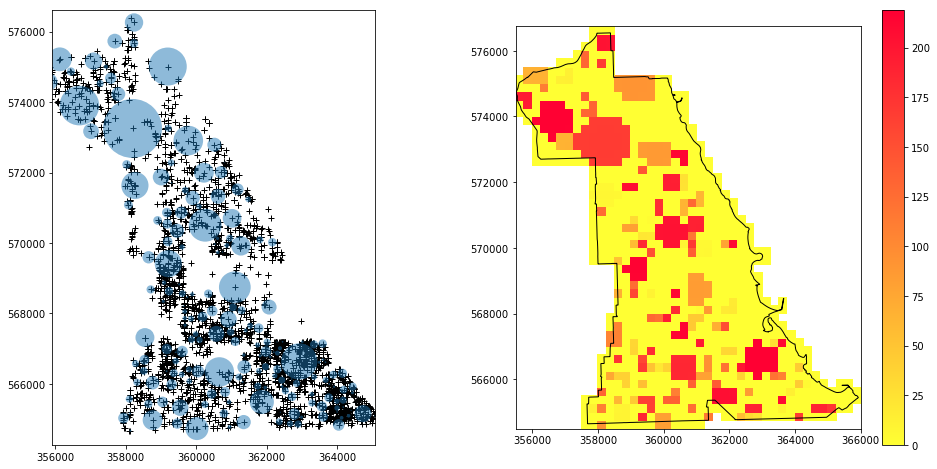

In [42]:
import matplotlib.patches

def plot_clusters(ax, coords, clusters):
    xmax, xmin = np.max(scanner.coords[0]), np.min(scanner.coords[0])
    xd = (xmax - xmin) / 100 * 5
    ax.set(xlim=[xmin-xd, xmax+xd])
    ymax, ymin = np.max(scanner.coords[1]), np.min(scanner.coords[1])
    yd = (ymax - ymin) / 100 * 5
    ax.set(ylim=[ymin-yd, ymax+yd])
    ax.set_aspect(1)
    for c in clusters:
        cir = matplotlib.patches.Circle(c.centre, c.radius, alpha=0.5)
        ax.add_patch(cir)
    ax.scatter(*coords, color="black", marker="+", linewidth=1)

def plot_grid_pred(ax, pred):
    cmap = ax.pcolormesh(*pred.mesh_data(), pred.intensity_matrix, cmap=yellow_to_red)
    fig.colorbar(cmap, ax=ax)
    ax.set_aspect(1)
    ax.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))

fig, axes = plt.subplots(ncols=2, figsize=(17,8))
plot_clusters(axes[0], trainer.data.coords, result.clusters)
plot_grid_pred(axes[1], pred)

## Grid and bin first

In [28]:
trainer1 = trainer.grid_coords(grid.region(), grid.xsize)
trainer1 = trainer1.bin_timestamps(np.datetime64("2017-01-01"), np.timedelta64(1, "D"))
trainer1.region = grid.region()

In [30]:
result1 = trainer1.predict()

In [31]:
result1.clusters[:10]

[Cluster(centre=array([ 363125.,  567125.]), radius=559.01699437494744),
 Cluster(centre=array([ 356625.,  573875.]), radius=559.01699437494744),
 Cluster(centre=array([ 359125.,  569375.]), radius=353.55339059327378),
 Cluster(centre=array([ 360375.,  569125.]), radius=500.0),
 Cluster(centre=array([ 360375.,  566875.]), radius=1030.7764064044152),
 Cluster(centre=array([ 362125.,  566375.]), radius=0.0),
 Cluster(centre=array([ 360625.,  572875.]), radius=250.0),
 Cluster(centre=array([ 362375.,  570125.]), radius=250.0),
 Cluster(centre=array([ 363625.,  565375.]), radius=0.0),
 Cluster(centre=array([ 358125.,  576375.]), radius=250.0)]

In [32]:
pred1 = result1.grid_prediction(grid.xsize)
pred1.mask_with(grid)

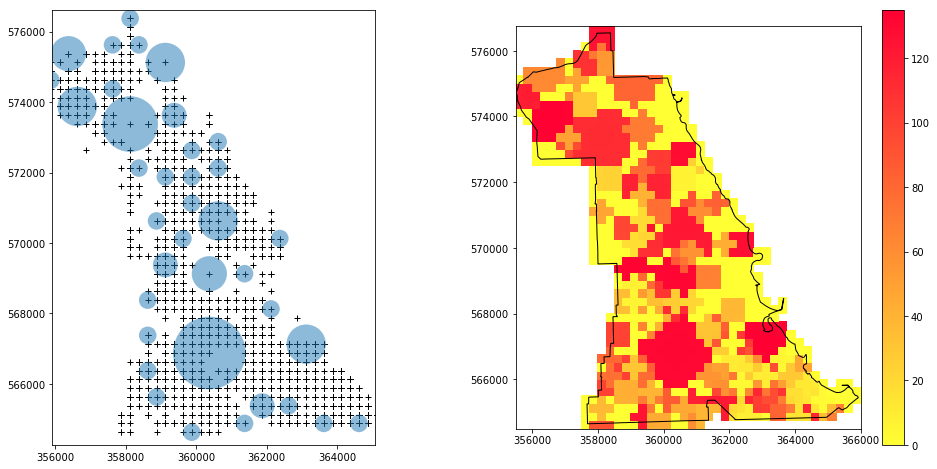

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(17,8))
plot_clusters(axes[0], trainer1.data.coords, result1.clusters)
plot_grid_pred(axes[1], pred1)

### Zero radius clusters

As you will see above, some of the clusters returned have zero radius (which makes sense, as having assigned all events to the middle of the grid cell they fall into, there will be clusters just consisting of the events in one grid cell).
  - We cannot see these in the plot above
  - But they do contribute to the gridded "risk" profile, hence the mismatch between the left and right plots.

Instead, it is possible to use the library to replace each cluster by the cluster with the same centre but with a radius enlarged to the maximum extent possible so that it contains no more events.
  - This is _not_ quite the same as still asking for the clusters not to overlap, as you can see.
  - It leads to a different risk profile.  It is not clear to me if this is "bettr" or not...

In [37]:
pred2 = result1.grid_prediction(grid.xsize, use_maximal_clusters=True)
pred2.mask_with(grid)

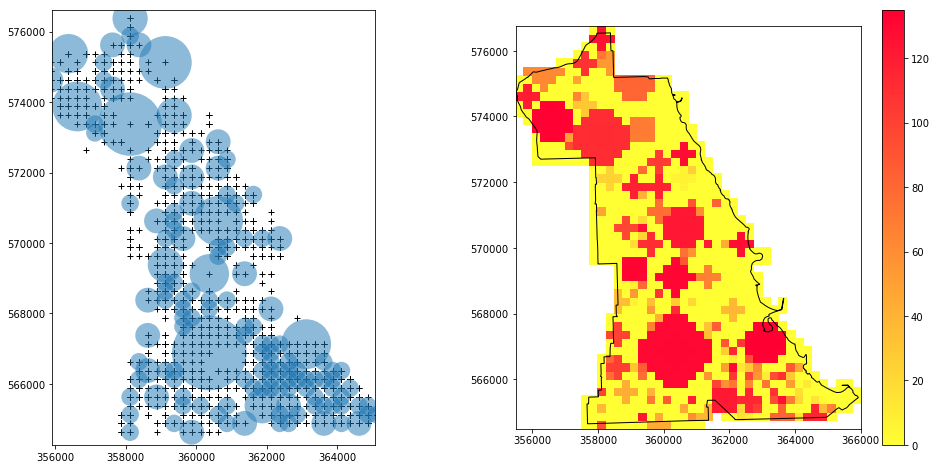

In [44]:
fig, axes = plt.subplots(ncols=2, figsize=(17,8))
plot_clusters(axes[0], trainer1.data.coords, result1.max_clusters)
plot_grid_pred(axes[1], pred2)

# Optimisation work

In [ ]:
time_masks, time_counts, times = scanner.make_time_ranges()
N = scanner.timestamps.shape[0]
centre = scanner.coords.T[0]
space_masks, space_counts, dists = scanner.find_discs(centre)
actual = scanner._calc_actual(space_masks, time_masks, time_counts)
expected = space_counts[:,None] * time_counts[None,:] / N
_mask = (actual > 1) & (actual > expected)
stats = scanner._ma_statistic(np.ma.array(actual, mask=~_mask),
                              np.ma.array(expected, mask=~_mask), N)
_mask1 = np.any(_mask, axis=1)
if not np.any(_mask1):
    raise Exception()
m = np.ma.argmax(stats, axis=1)[_mask1]
stats1 = stats[_mask1,:]
stats2 = stats1[range(stats1.shape[0]),m].data
used_dists = dists[_mask1]
used_times = times[m]


In [ ]:
%timeit( scanner.find_discs(centre) )

In [ ]:
%timeit( np.sum(space_masks[:,:,None] & time_masks[:,None,:], axis=0) )

In [ ]:
%timeit(scanner._calc_actual(space_masks, time_masks, time_counts))

In [ ]:
np.testing.assert_allclose(scanner._calc_actual(space_masks, time_masks, time_counts),
            np.sum(space_masks[:,:,None] & time_masks[:,None,:], axis=0))

In [ ]:
%timeit(space_counts[:,None] * time_counts[None,:] / N)

In [ ]:
%timeit((actual > 1) & (actual > expected))

In [ ]:
%timeit(scanner._ma_statistic(np.ma.array(actual, mask=~_mask), np.ma.array(expected, mask=~_mask), N))

In [ ]:
log_lookup = np.log(np.array([1] + list(range(1,N+1))))
log_lookup2 = np.log(np.array([1] + list(range(1,N*N+1))))

In [ ]:
sh = (space_counts.shape[0], time_counts.shape[0])
s = np.ma.array(np.broadcast_to(space_counts[:,None], sh), mask=~_mask)
t = np.ma.array(np.broadcast_to(time_counts[None,:], sh), mask=~_mask)

a = np.ma.array(actual, mask=~_mask)
e = np.ma.array(s*t, mask=~_mask) / N
x1 = a * np.ma.log(a/e)

Nl = np.log(N)
aa = a.astype(np.int)
y1 = a * (Nl + log_lookup[aa] - log_lookup[s] - log_lookup[t])
assert np.ma.max(np.ma.abs(x1-y1)) < 1e-10

x2 = (N-a) * (np.ma.log(N-a) - np.ma.log(N-e))
y2 = (N-a) * (Nl + log_lookup[N-aa] - np.ma.log(N*N-s*t))
assert np.ma.max(np.ma.abs(x2-y2)) < 1e-10

In [ ]:
aa = actual.astype(np.int)
def f():
    sl = log_lookup[space_counts]
    tl = log_lookup[time_counts]
    st = N*N - space_counts[:,None] * time_counts[None,:]

    Nl = np.log(N)
    y = aa * (Nl + log_lookup[aa] - sl[:,None] - tl[None,:])
    yy = (N-aa) * (Nl + log_lookup[N-aa] - log_lookup2[st])
    return np.ma.array(y + yy, mask=~_mask)

stats = scanner._ma_statistic(np.ma.array(actual, mask=~_mask),
                              np.ma.array(expected, mask=~_mask), N)

np.ma.max(np.ma.abs(stats - f()))

In [ ]:
%timeit(f())

In [ ]:
%timeit(np.any(_mask, axis=1))

In [ ]:
%timeit(np.ma.argmax(stats, axis=1)[_mask1])

In [ ]:
%timeit(stats[_mask1,:])

In [ ]:
%timeit(stats1[range(stats1.shape[0]),m].data)

In [ ]:
%timeit(dists[_mask1])

In [ ]:
%timeit(times[m])

In [ ]:
def f():
    x = scanner.faster_score_all()
    return next(x)

def f1():
    x = scanner.faster_score_all_new()
    return next(x)

a = f()
a1 = f1()
for i in range(4):
    np.testing.assert_allclose(a[i], a1[i])

In [ ]:
# Compare against the old slow method

def find_chunk(ar, start_index):
    x = (ar == ar[start_index])
    end_index = start_index
    while end_index < len(ar) and x[end_index]:
        end_index += 1
    return end_index

x = scanner.faster_score_all_old()
a2 = next(x)
start_index = 0
for index in range(len(a1[1])):
    end_index = find_chunk(a2[1], start_index)
    i = np.argmax(a2[3][start_index:end_index])
    for j in range(1,4):
        assert abs(a2[j][start_index+i] - a1[j][index]) < 1e-10
    start_index = end_index

In [ ]:
%timeit(f())

In [ ]:
%timeit(f1())

In [ ]:
import datetime
x = scanner.faster_score_all()

for _ in range(20):
    now = datetime.datetime.now()
    next(x)
    print(datetime.datetime.now() - now)

In [ ]:
next(scanner.find_all_clusters())